### Classify digits with or witout circles using Support Vector Machine (SVM)

The goal of SVM is to find a hyperplane that maximizes the margin between two classes. Given a dataset of $N$ samples $(x_i, y_i)$ where $x_i \in \mathbb{R}^d$ is the feature vector and $y_i \in \{-1, 1\}$ is the class label, we aim to solve the following optimization problem:

$$
\text{minimize } J(w, b) = \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \max\left(0, 1 - y_i (w \cdot x_i + b)\right)
$$

### Definitions

- $w$: Weight vector (coefficients of the features).
- $b$: Bias term (intercept of the hyperplane).
- $C$: Regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification error.
- $N$: Number of training samples.
- $d$: Number of features in each sample.

### Load dataset

In [1]:
import gzip
import os
import numpy as np
import struct


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        _, _ = struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        _, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(num, rows*cols)

    return images, labels

In [2]:
from sklearn.preprocessing import StandardScaler

# Load the dataset
mnist_path = '../../../supplemental_material/MNIST' 
X_train, y_train = load_mnist(mnist_path, kind='train')
X_test, y_test = load_mnist(mnist_path, kind='t10k')

print(f"Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}")

# Define the digits with and without circles
circle_digits = [0, 6, 8, 9]
no_circle_digits = [1, 2, 3, 4, 5, 7]

# Filter the training and test sets to include only the relevant digits
train_mask = np.isin(y_train, circle_digits + no_circle_digits)
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = np.isin(y_test, circle_digits + no_circle_digits)
X_test, y_test = X_test[test_mask], y_test[test_mask]

# Relabel the data: 1 for circle digits, 0 for no-circle digits
y_train = np.where(np.isin(y_train, circle_digits), 1, 0)
y_test = np.where(np.isin(y_test, circle_digits), 1, 0)

# Normalize the data (important for gradient descent)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training set shape: (60000, 784), Training labels shape: (60000,)
Test set shape: (10000, 784), Test labels shape: (10000,)


### SVM class

In [3]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.num_iterations = num_iterations
        self.w = None
        self.b = None

    def fit(self, X, y):
        _, num_features = X.shape
        y = np.where(y <= 0, -1, 1)  # Convert labels to -1 and 1 for SVM

        # Initialize weights and bias
        self.w = np.zeros(num_features)
        self.b = 0

        # Gradient descent
        for _ in range(self.num_iterations):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    # If the point is correctly classified and outside the margin
                    dw = 2 * self.lambda_param * self.w
                    db = 0
                else:
                    # If the point is inside the margin or misclassified
                    dw = 2 * self.lambda_param * self.w - np.dot(x_i, y[idx])
                    db = y[idx]

                # Update weights and bias
                self.w -= self.learning_rate * dw
                self.b -= self.learning_rate * db

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)




### Train the SVM model

In [4]:
# Initialize and train the SVM model
svm = SVM(learning_rate=0.001, lambda_param=0.01, num_iterations=1000)
svm.fit(X_train[:10000], y_train[:10000])

# Predict on the test set
y_pred_test = svm.predict(X_test[:2000])

# Convert predictions back to 0 and 1
y_pred_test = np.where(y_pred_test == -1, 0, 1)

Test accuracy: 84.25%


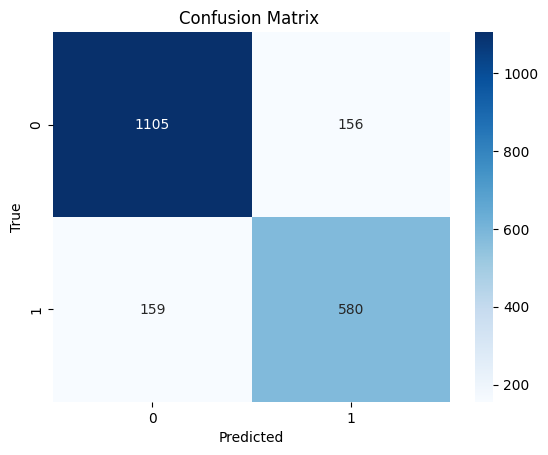

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1261
           1       0.79      0.78      0.79       739

    accuracy                           0.84      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.84      0.84      0.84      2000



In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
test_accuracy = accuracy_score(y_test[:2000], y_pred_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test[:2000], y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix ')
plt.show()

print("Classification Report:")
print(classification_report(y_test[:2000], y_pred_test))